<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Macros/TrainCRV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init

In [2]:
import sys

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/My Drive/'
except:
    main_path = ''
sys.path.append(main_path)

Mounted at /content/drive


In [3]:
!pip install --upgrade tables
!pip install uproot3


     |████████████████████████████████| 4.3 MB 4.3 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 117 kB 4.1 MB/s 
     |████████████████████████████████| 87 kB 5.9 MB/s 


In [4]:
import uproot3
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from plotly import graph_objs as go
import pylab
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)
plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

#Keras libs
import keras
from keras.models import Sequential, Model, Input
from keras.layers.core import Dense, Activation
from keras.layers import BatchNormalization, Dropout, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.models import load_model

import math
import sklearn.utils
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import brier_score_loss
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, plot_confusion_matrix
import string
from decimal import Decimal
from mpl_toolkits.axisartist.axislines import AxesZero
import pickle

#Define var list and cuts

In [5]:
dTZPE_noMom_variables_list = {
                  'crvinfo__z': [-5000, 20000],
                  'crvinfo__PEs': [-1, 1000],
                  'crvinfo__dT': [-500, 500],
                  'crvinfo__nCoincidenceHits': [0, 50],
#                  'de_nhits': [-2, 100],
                  # 'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
#                  'dequal_TrkQual': [-0.1, 1.1],
#                  'deent_td': [0, 10],
#                  'deent_z0': [-500,500],
                  }

#Default MDC-style cut box
cuts = [
    "(de_status > 0)",
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 105)",
    "((deent_d0 + 2./deent_om) > 450)",
    "((deent_d0 + 2./deent_om) < 680)",
    "(is_triggered)"
]
cut_tbox = " & ".join(cuts)
#PID, TrkQual and cut on events with an usptream leg
cuts = [
    "(dequal_TrkQual > 0.8)",
    "(dequal_TrkPID > 0.95)",
    "(ue_status <= 0)"
]
cut_pid_trkqual_ue = " & ".join(cuts)
# Extended momentum window cut`
cuts = [
    "(deent_mom > 100)",
    "(deent_mom < 115)"
]
cut_extmom = " & ".join(cuts)
cuts = [
    "(deent_mom > 103.85)",
    "(deent_mom < 105.1)"
]
cut_phymom = " & ".join(cuts)
# Loose box cuts
cuts = [
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 205)",
    "((deent_d0 + 2./deent_om) > 450)",
    "(is_triggered)"
]

crv_time = "( ((-de_t0 + crvinfo__timeWindowStart) > 50) | ((de_t0-crvinfo__timeWindowStart) > 150.0)) "
cut_lbox = " & ".join(cuts)
cut_lbox = " & ".join(cuts)

In [6]:
#Combime cuts
cut_nomom  = cut_tbox +" & "+cut_pid_trkqual_ue
cut_extmom_orig = cut_extmom
cut_extmom =  cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_extmom
cut_phymom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_phymom
cut_loose  = cut_lbox +" & "+cut_pid_trkqual_ue

#Load training dataframe

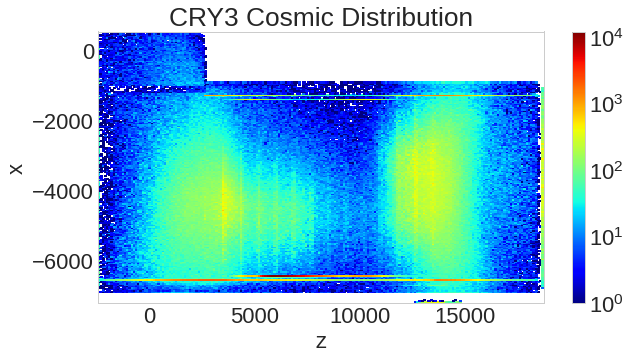

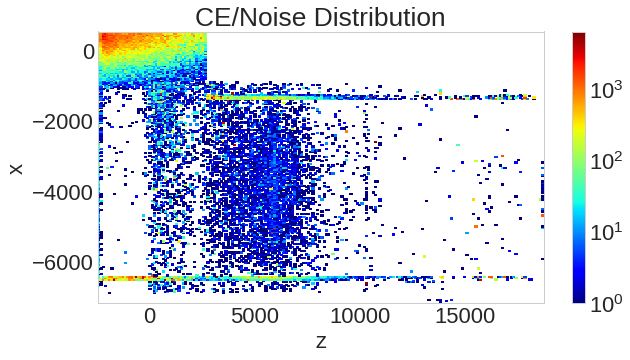

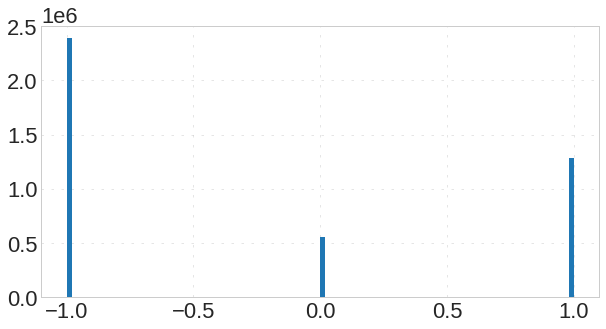

In [7]:
# Load dataframe
df = pd.read_hdf(main_path+"Saved_Data/TrainingDataCRY3CE.h5")

#Plot basic variables
plotted = df.query('(is_high != -1) & crvinfo__timeWindowStart>0')
plt.hist2d(plotted['crvinfomc__z'], plotted['crvinfomc__x'], bins=(200,200), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet);
plt.colorbar();
plt.title("CRY3 Cosmic Distribution");
plt.xlabel("z");
plt.ylabel("x");

plt.figure()
plotted = df.query('(is_high == -1) & crvinfo__timeWindowStart>0')
plt.hist2d(plotted['crvinfomc__z'], plotted['crvinfomc__x'], bins=(200,200), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet);
plt.colorbar();
plt.title("CE/Noise Distribution");
plt.xlabel("z");
plt.ylabel("x");

plt.figure()
plt.hist(df['is_high'], bins=100);

#Create training and validation datasets

In [8]:
selector='('+cut_extmom+'& is_cosmic==0'+') | is_cosmic==1'
onlyCRV = df[(df['crvinfo__PEs']>=-1)] #Data Filtration
onlyCRV = onlyCRV.query(selector)
var_list=list(dTZPE_noMom_variables_list.keys())
var_list.append('is_cosmic')
onlyCRV = onlyCRV[var_list]

In [9]:
y_CRV = onlyCRV['is_cosmic']
X_CRV = onlyCRV.drop('is_cosmic', 1)
CRV_X_train_df, CRV_X_val_df, CRV_y_train, CRV_y_val = train_test_split(X_CRV, y_CRV, test_size=0.25, random_state=1)
CRV_y_train = np.ravel(CRV_y_train).flatten()
CRV_y_val = np.ravel(CRV_y_val).flatten()

CRVscaler = StandardScaler().fit(X_CRV)
CRV_X_train = CRVscaler.transform(CRV_X_train_df)
CRV_X_val = CRVscaler.transform(CRV_X_val_df)

In [10]:
'''
with open(main_path+"Saved_Data/CoincidenceTrainer.pkl", "wb+") as f:
  pickle.dump([CRV_y_train, CRV_y_val, CRVscaler, CRV_X_train, CRV_X_val, CRV_X_train_df, CRV_X_val_df], f)
with open(main_path+"Saved_Data/CoincidenceTestingCE.pkl", "wb+") as f:
  pickle.dump([CRV_y_test, CRV_X_test_df], f)
'''

'\nwith open(main_path+"Saved_Data/CoincidenceTrainer.pkl", "wb+") as f:\n  pickle.dump([CRV_y_train, CRV_y_val, CRVscaler, CRV_X_train, CRV_X_val, CRV_X_train_df, CRV_X_val_df], f)\nwith open(main_path+"Saved_Data/CoincidenceTestingCE.pkl", "wb+") as f:\n  pickle.dump([CRV_y_test, CRV_X_test_df], f)\n'

#Train model

In [11]:
X_train = CRV_X_train
y_train = CRV_y_train
X_val = CRV_X_val
y_val = CRV_y_val

In [12]:
keras.backend.clear_session() #This clears the previous training
model = keras.Sequential()
widthMultiplier = 2
depth = 2 
batch = 1000

width = round(len(X_train[0])*widthMultiplier)
model.add(Dense(len(X_train[0]), input_dim=len(X_train[0]), kernel_initializer='normal', activation='relu'))
model.add(Dense(width, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train, epochs=200, batch_size=batch, validation_data=(X_val, y_val), verbose=True);

Epoch 1/200
1674/1674 [==============================] - 5s 3ms/step - loss: 0.1262 - accuracy: 0.9639 - val_loss: 0.0423 - val_accuracy: 0.9859
Epoch 2/200
1674/1674 [==============================] - 3s 2ms/step - loss: 0.0330 - accuracy: 0.9884 - val_loss: 0.0268 - val_accuracy: 0.9906
Epoch 3/200
1674/1674 [==============================] - 3s 2ms/step - loss: 0.0246 - accuracy: 0.9914 - val_loss: 0.0225 - val_accuracy: 0.9922
Epoch 4/200
1674/1674 [==============================] - 3s 2ms/step - loss: 0.0222 - accuracy: 0.9923 - val_loss: 0.0213 - val_accuracy: 0.9924
Epoch 5/200
1674/1674 [==============================] - 3s 2ms/step - loss: 0.0213 - accuracy: 0.9926 - val_loss: 0.0214 - val_accuracy: 0.9925
Epoch 6/200
1674/1674 [==============================] - 3s 2ms/step - loss: 0.0206 - accuracy: 0.9928 - val_loss: 0.0204 - val_accuracy: 0.9929
Epoch 7/200
1674/1674 [==============================] - 3s 2ms/step - loss: 0.0201 - accuracy: 0.9931 - val_loss: 0.0196 - val_ac

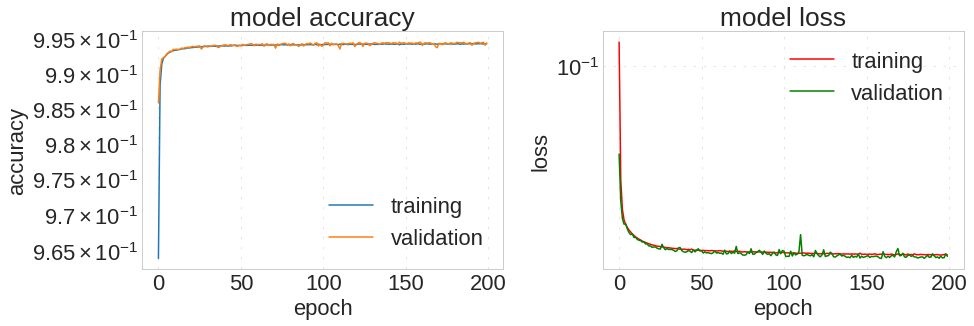

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14,5))

ax1.plot(history.history['accuracy'], label="training");
ax1.plot(history.history['val_accuracy'], label="validation");
ax1.set_title('model accuracy');
ax1.set_ylabel('accuracy');
ax1.set_xlabel('epoch');
ax1.legend(loc='bottom right');
#ax1.set_ylim(0.9,1);
ax1.set_yscale('log');

ax2.plot(history.history['loss'], 'r-', label="training")
ax2.plot(history.history['val_loss'], 'g-', label="validation")
ax2.set_title('model loss');
ax2.set_ylabel('loss');
ax2.set_xlabel('epoch');
ax2.legend(loc='best');
#ax2.set_ylim(0,0.1);
ax2.set_yscale('log');
plt.tight_layout();
plt.show()

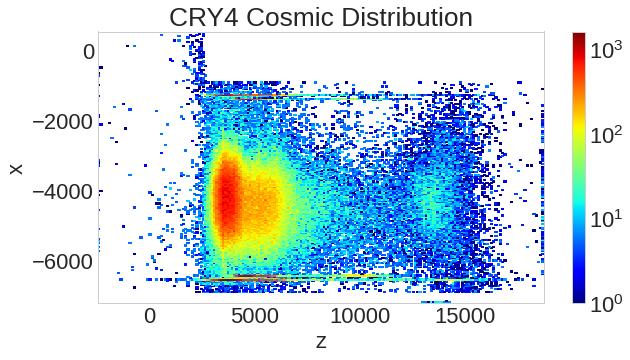

In [14]:
try:
    variousYields
except NameError:
    variousYields = pd.read_hdf(main_path + "root_files_cry4/cry4df.h5").query(cut_loose)

plotted = variousYields.query('crvinfo__timeWindowStart>0')

plt.hist2d(plotted['crvinfomc__z'], plotted['crvinfomc__x'], bins=(200,200), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet);
plt.colorbar();
plt.title("CRY4 Cosmic Distribution");
plt.xlabel("z");
plt.ylabel("x");

In [15]:
noise = df.query(cut_extmom+'& is_cosmic==0 & crvinfo__PEs>-1') 
noise_X_test = CRVscaler.transform(noise[list(dTZPE_noMom_variables_list.keys())])
withCRV = variousYields[(variousYields['crvinfo__PEs']>-1)] 
withCRV_X_test = CRVscaler.transform(withCRV[list(dTZPE_noMom_variables_list.keys())])
withCRV_X_pred = model.predict(withCRV_X_test)
withCRV['pred'] = withCRV_X_pred.flatten().tolist()

withCRV_X_pred = model.predict(noise_X_test)
noise['pred'] = withCRV_X_pred.flatten().tolist()

9000
11000
13000
15000
17000


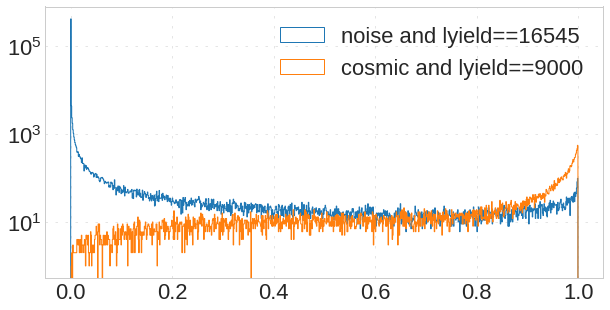

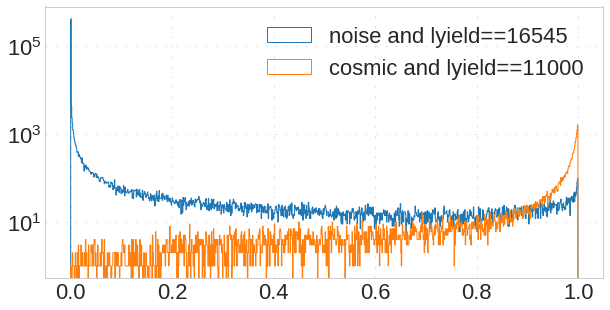

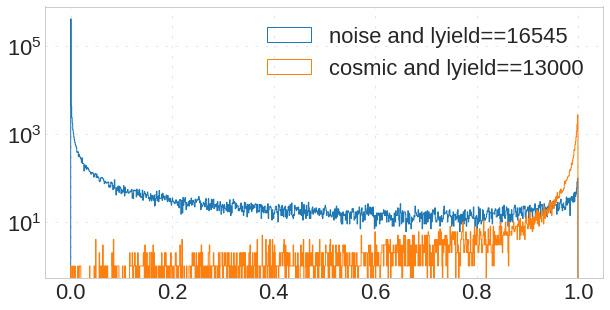

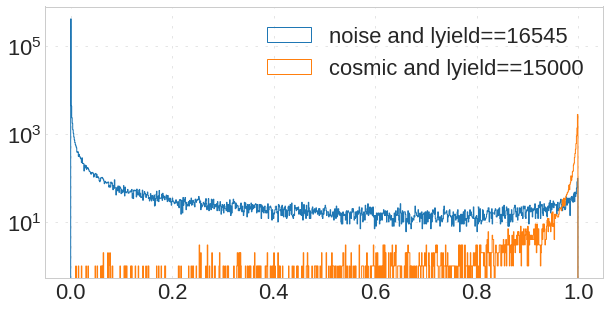

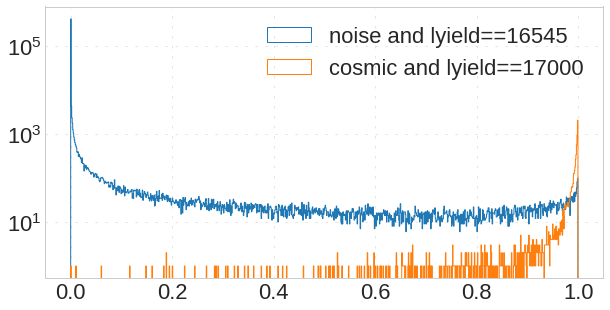

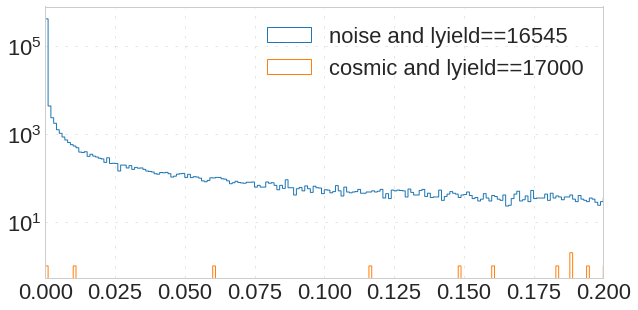

In [41]:
for lyield in range(9000, 17001, 2000):
  print(lyield)
  plt.figure()
  plt.hist(noise['pred'], bins=np.arange(0,1.0, 0.001), histtype='step', label='noise and lyield==16545');
  plt.hist(withCRV.query(cut_extmom+'& lyield==%d'%lyield)['pred'], bins=np.arange(0,1.0, 0.001), histtype='step', label='cosmic and lyield==%d'%lyield);
  plt.yscale('log')
  plt.legend()

plt.figure()
plt.hist(noise['pred'], bins=np.arange(0,1.0, 0.001), histtype='step', label='noise and lyield==16545');
plt.hist(withCRV.query(cut_extmom+'& lyield==17000')['pred'], bins=np.arange(0,1.0, 0.001), histtype='step', label='cosmic and lyield==17000');
plt.yscale('log')
plt.xlim(0, 0.2)
plt.legend()


Text(0, 0.5, 'Background efficiency')

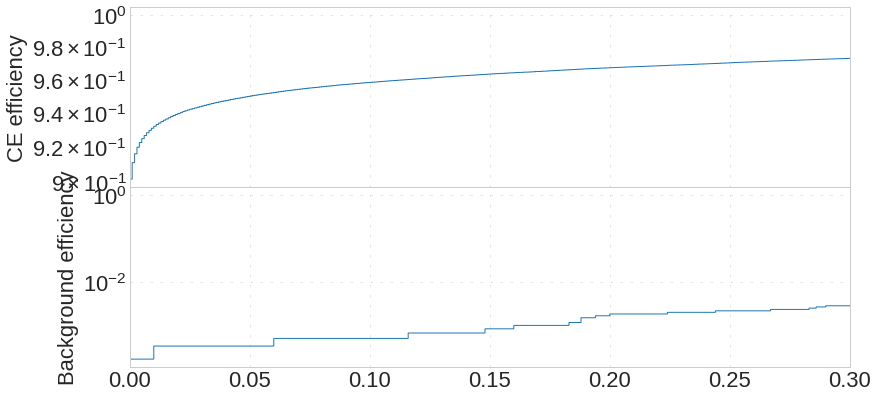

In [28]:
fig.subplots_adjust(hspace=0)
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.subplots_adjust(0,0,1,1,0,0)

ax1.hist(noise['pred'], bins=np.arange(0,1.0, 0.001), histtype='step', cumulative=True, density=True, label='noise and lyield==16545');
ax1.set_yscale('log')
ax1.set_ylabel('CE efficiency')

ax2.hist(withCRV.query(cut_extmom+'& lyield==17000')['pred'], bins=np.arange(0,1.0, 0.001), histtype='step', cumulative=True, density=True, label='cosmic and lyield==17000');
plt.yscale('log')
plt.xlim(0,0.3)
ax2.set_ylabel('Background efficiency')


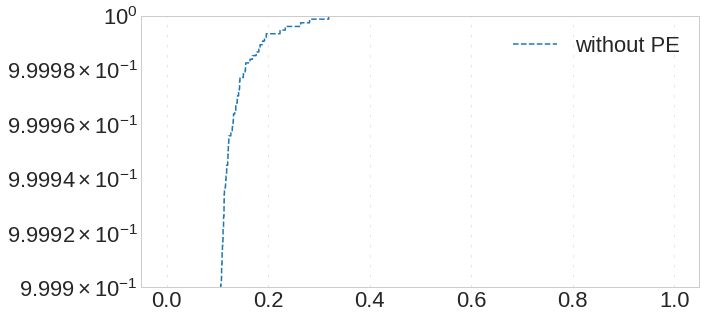

In [29]:
withCRV['is_cosmic'] = 1
x_combo = withCRV['pred'].append(noise['pred']).to_numpy()
y_combo = withCRV['is_cosmic'].append(noise['is_cosmic']).to_numpy()
fpr, tpr, _ = roc_curve(y_combo, x_combo)

plt.plot(fpr, tpr, linestyle='--', label='without PE')
plt.yscale('log')
plt.ylim(0.9999, 1)
plt.legend()

In [38]:
nncut=0.2
withCRV.query(cut_extmom+'& lyield==17000 & pred<%f'%nncut)[['is_high', '_z', 'dequal_TrkQual', 'crvinfo__PEs', 'crvinfo__dT']]

,is_high,_z,dequal_TrkQual,crvinfo__PEs,crvinfo__dT
entry,,,,,
175368,0,5878.0,1.0,83.0,17.4
289161,0,3539.2,1.0,86.0,-15.4
490458,0,18675.7,1.0,118.0,-56.5
208971,0,6114.9,1.0,117.0,23.7
316878,0,1266.5,1.0,135.0,-7.6
517311,0,7059.6,1.0,49.0,-3.9
1140638,0,4716.6,1.0,103.0,-27.1
1354408,0,7581.1,1.0,163.0,-52.4
1381008,0,5366.1,1.0,98.0,17.9


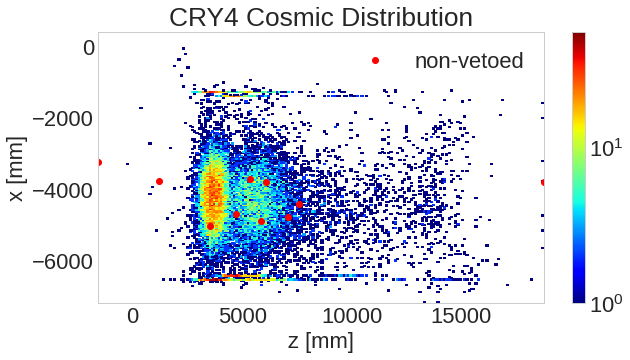

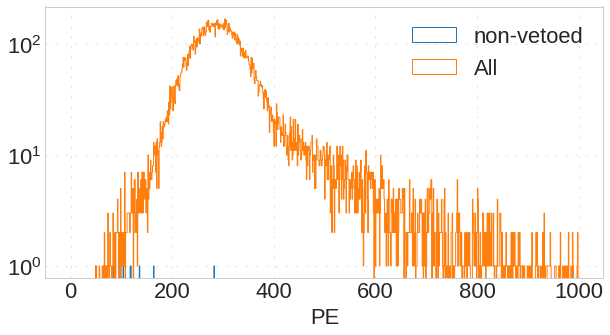

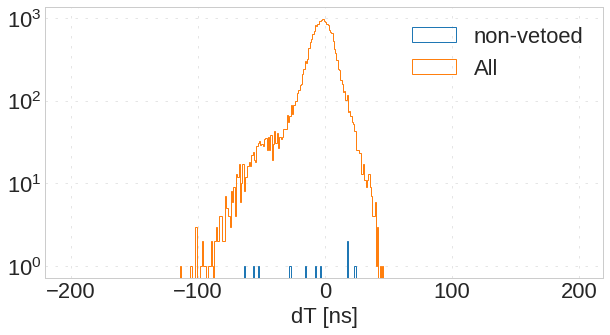

In [40]:
plotted_all = variousYields.query(cut_extmom+'& crvinfo__timeWindowStart>0 & lyield==17000')
plotted = withCRV.query(cut_extmom+'& crvinfo__timeWindowStart>0 & lyield==17000 & pred<%f'%nncut)

plt.hist2d(plotted_all['crvinfomc__z'], plotted_all['crvinfomc__x'], bins=(200,200), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet);
plt.colorbar();
plt.title("CRY4 Cosmic Distribution");
plt.xlabel("z [mm]");
plt.ylabel("x [mm]");

plt.plot(plotted['crvinfomc__z'], plotted['crvinfomc__x'], 'ro', label='non-vetoed');
plt.legend()

plt.figure()
plt.hist(plotted['crvinfo__PEs'], bins=range(0,1000,1), histtype='step', label='non-vetoed');
plt.hist(plotted_all['crvinfo__PEs'], bins=range(0,1000,1), histtype='step', label='All');
plt.xlabel('PE')
plt.yscale('log')
plt.legend()

plt.figure()
plt.hist(plotted['crvinfo__dT'], bins=range(-200,200,1), histtype='step', label='non-vetoed');
plt.hist(plotted_all['crvinfo__dT'], bins=range(-200,200,1), histtype='step', label='All');
plt.xlabel('dT [ns]')
plt.yscale('log')
plt.legend()
